In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyautogui
from PIL import Image
import imutils
import collections
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import time
import scipy
%matplotlib inline

In [2]:
Box = collections.namedtuple('Box', 'left top width height')

In [3]:
### for some reason screen size and screenshot size are not same but scaled
screen_size = pyautogui.size()
print("Screen size: {}".format(screen_size))
screenshot_size = np.array(pyautogui.screenshot()).shape[1::-1]
print("Screenshot size: {}".format(screenshot_size))
scale = screenshot_size[0]/screen_size[0]
scale

Screen size: Size(width=1920, height=1080)
Screenshot size: (1920, 1080)


1.0

In [5]:
region = pyautogui.locateOnScreen('game_region_windows.png')
print(region)

Box(left=1195, top=167, width=460, height=861)


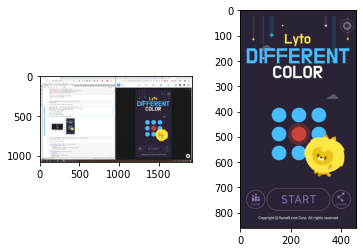

In [6]:
game_region_img = cv2.imread('game_region_windows.png')
game_region_img = cv2.cvtColor(game_region_img, cv2.COLOR_BGR2RGB)
start_screen = np.array(pyautogui.screenshot())
start_screen = start_screen[..., :3]
f, ax = plt.subplots(1, 2)
ax[0].imshow(start_screen)
ax[1].imshow(game_region_img)

In [7]:
res = cv2.matchTemplate(game_region_img, start_screen, cv2.TM_CCOEFF_NORMED)
np.where(res > 0.99)

(array([167], dtype=int64), array([1195], dtype=int64))

In [8]:
def moveToCenter(box, duration = 0, physical=False):
    x, y, width, height = box
    if physical:
        moveTo(x+width/2, y+height/2, duration, physical)
    return x+width/2, y+height/2

In [9]:
def findInImage(needle, haystack, err=0.05):
    max_cor = 0
    correct_size = 1
    needle_corrected = needle.copy()
    max_res = None
    sample_size = int(1/err)
    for s in np.linspace(0, 1.0, sample_size)[:0:-1]:
        # resize the image according to the scale, and keep track
        # of the ratio of the resizing
        resized = imutils.resize(needle, width = int(needle.shape[1] * s))
        res = cv2.matchTemplate(resized, haystack, cv2.TM_CCOEFF_NORMED)
        cor = res.max()
        print(cor)
        if max_cor < cor:
            max_cor = cor
            max_res = res
            correct_size = s
            needle_corrected = resized
            
    coordinates = np.where(max_res==max_cor)
    x, y = coordinates[1][0], coordinates[0][0]
    height, width = needle_corrected.shape[0], needle_corrected.shape[1]
    
    return Box(x, y, width, height)

In [10]:
def locateOnScreen(img_path, err=0.05):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    screen = np.array(pyautogui.screenshot())
    screen = screen[..., :3]
    return findInImage(img, screen, err)

1.0


Box(left=1195, top=167, width=460, height=861)

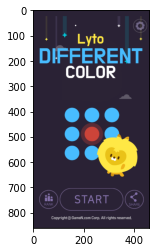

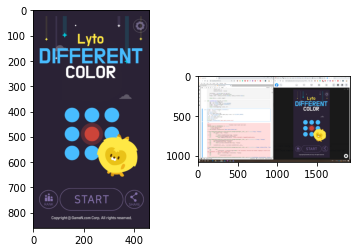

In [12]:
screen = np.array(pyautogui.screenshot())
screen = screen[..., :3]
plt.imshow(screen)
plt.imshow(game_region_img)
res = cv2.matchTemplate(game_region_img, screen, cv2.TM_CCOEFF_NORMED)
f, ax = plt.subplots(1,2)
ax[0].imshow(game_region_img)
ax[1].imshow(screen)
print(res.max())
pyautogui.locateOnScreen('game_region_windows.png')

In [13]:
x, y, width, height = game_region
print(game_region)

NameError: name 'game_region' is not defined

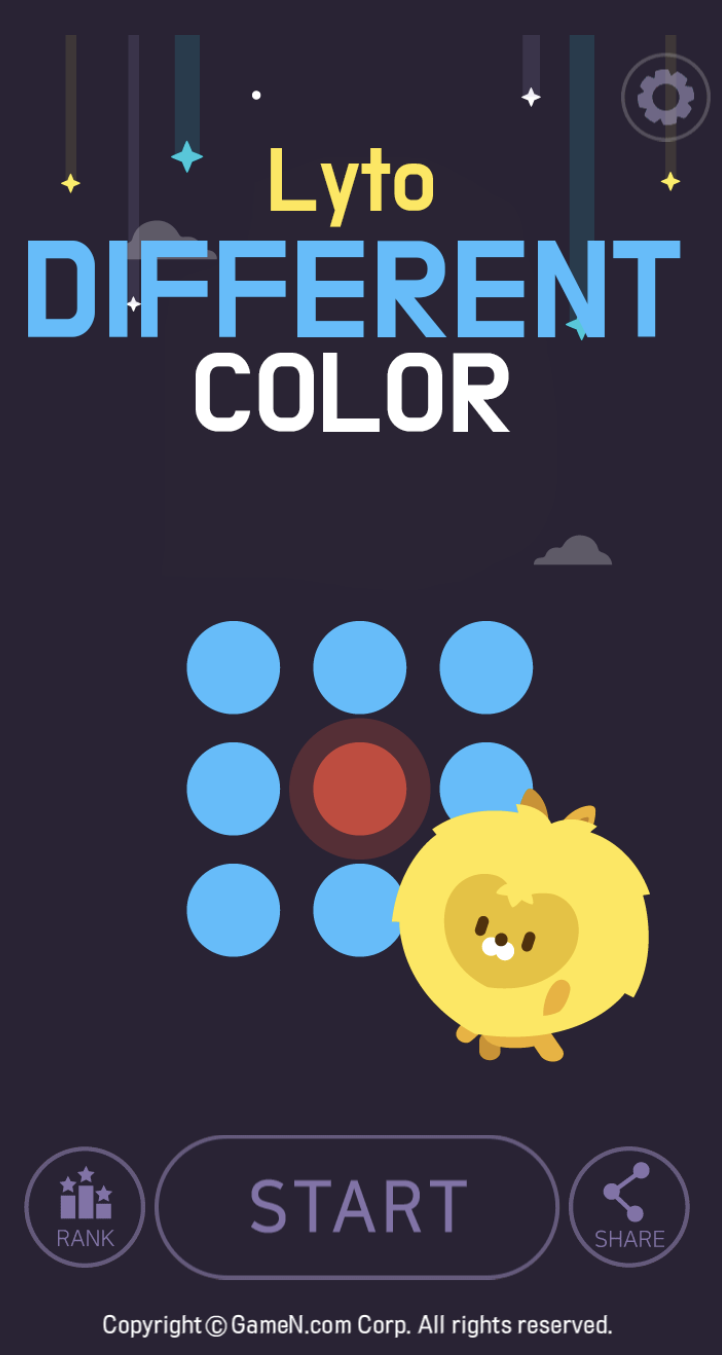

In [304]:
pyautogui.screenshot(region = game_region)

In [291]:
moveTo(x+width, y+height)

In [299]:
start_button = locateOnScreen('start_button.png')
print(start_button)

Box(left=729, top=1499, width=403, height=151)


In [57]:
pyautogui.doubleClick((start_button.left + start_button.width/2)/scale, (start_button.top + start_button.height/2)/scale)

In [303]:
moveToCenter(start_button)

In [59]:
game_play = pyautogui.screenshot(region = region)

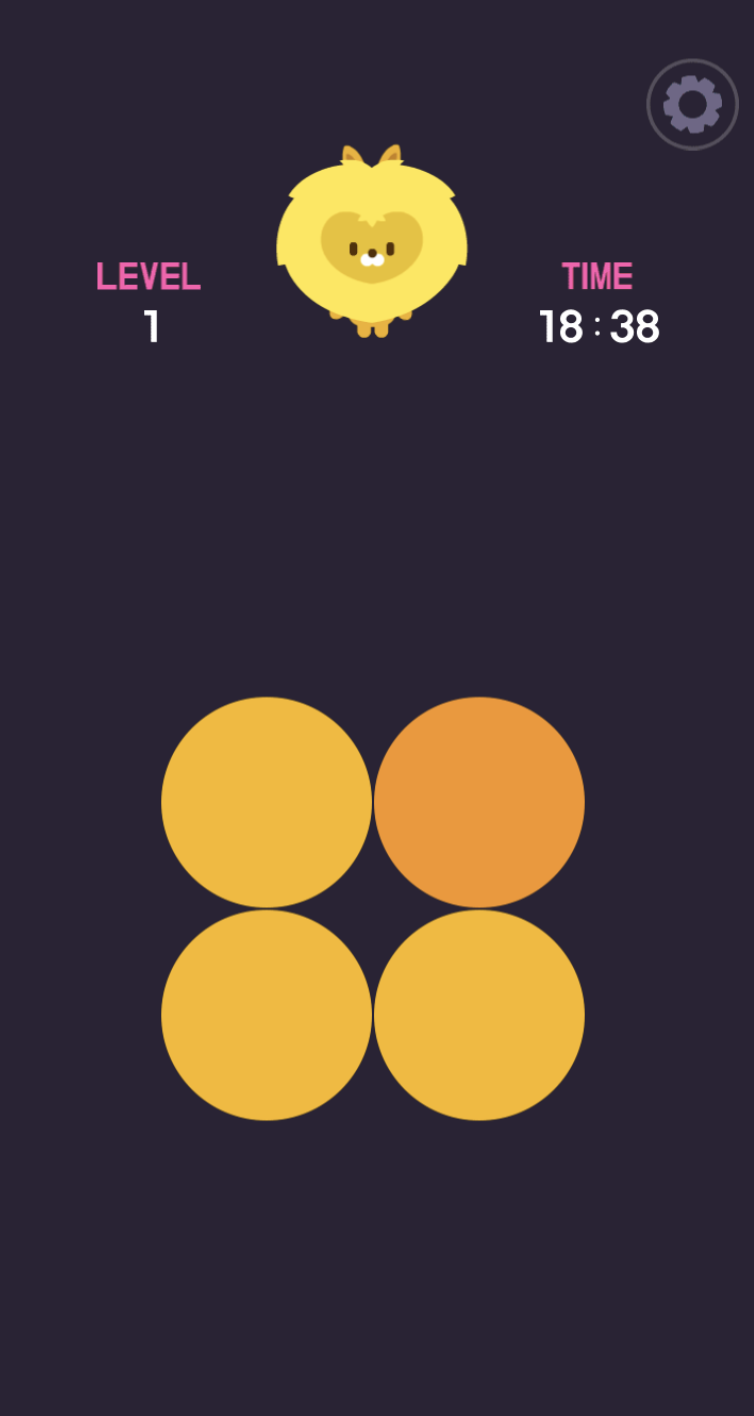

In [305]:
game_play

In [69]:
#clf = LocalOutlierFactor(n_neighbors=3)
clf = OneClassSVM()
import random
def oddOneOut(game_play):
    game_play_np = np.array(game_play)
    output = game_play_np.copy()
    gray = cv2.cvtColor(game_play_np, cv2.COLOR_BGR2GRAY)
    a = random.uniform(1.1,1.5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, a, 1)
    
    # ensure at least 5 circles were found
    if circles is not None and circles.shape[1] >= 4:
        # convert the (x, y) coordinates and radius of the circles to integers
        np_circles = np.round(circles[0, :]).astype("int")
        #print(np_circles)
        # make sure all circles are the targeted circles
        # clustering the points based on coordinates
        #kmeans = KMeans(n_clusters=2, random_state=0).fit(np_circles[..., :2])
        #labels = kmeans.labels_
        #labels = clf.fit_predict(np_circles)
        #print(labels)
        #major = scipy.stats.mode(labels).mode
        #print(major)
        modes = scipy.stats.mode(np_circles).mode
        cond = np.abs(np_circles[..., 2:]-modes[..., 2:]) <= 2
        targets = np_circles[cond.flatten()]
        #print(targets)

        colors = []
        for target in targets:
            x, y = target[0], target[1]
            colors.append(game_play_np[y,x,:])
        colors = np.array(colors)
        #print(colors)
        labels = clf.fit_predict(colors[..., :3])
        #print(labels)
        # identify the odd based on color
        #mean = colors.mean(axis=0)
        #std = colors.std(axis=0)
        mode = scipy.stats.mode(colors, axis=0).mode
        #print(colors != mode)
        outliers_idx = np.where(np.any(colors != mode, axis=1))
        #print(outliers_idx)
        from sklearn.metrics.pairwise import euclidean_distances
        #print(colors[outliers_idx])
        distances = euclidean_distances(colors[outliers_idx], mode)
        eliminated_id = outliers_idx[0][np.argmin(distances)]
        x_elim = targets[eliminated_id, 0]
        y_elim = targets[eliminated_id, 1]
        return (x_elim, y_elim)

In [24]:
x, y = oddOneOut(game_play)
x,y

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by check_pairwise_arrays.

In [343]:
moveInGame(x,y, game_region)

In [68]:
import random
random.uniform(1.1,1.5)

1.1296890083995452

In [83]:
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    np_circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in np_circles:
        print(x,y,r)
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

479 802 106
266 802 106
266 1016 105
478 1016 106
692 105 43


In [352]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(np_circles)

In [364]:
labels = kmeans.labels_
major = mode(labels)
print(major)
kmeans.labels_ == major
np_circles[kmeans.labels_ == major]

1


array([[ 479,  802,  106],
       [ 266,  802,  106],
       [ 266, 1016,  105],
       [ 478, 1016,  106]])

In [96]:
mean, std = radii.mean(), radii.std()
outliers = np.where(np.abs(radii - mean) > std)
outliers

(array([4]),)

In [104]:
targets = np.array([c for pos, c in enumerate(np_circles) if pos not in outliers ])

In [105]:
targets

array([[ 479,  802,  106],
       [ 266,  802,  106],
       [ 266, 1016,  105],
       [ 478, 1016,  106]])

In [143]:
colors = []
for target in targets:
    x, y = target[0], target[1]
    colors.append(game_play_np[y,x,:])
colors = np.array(colors)
colors

array([[233, 153,  63, 255],
       [239, 186,  67, 255],
       [239, 186,  67, 255],
       [239, 186,  67, 255]], dtype=uint8)

In [16]:
def moveTo (x, y, interval = 0, physical=False):
    x_, y_ = x/scale, y/scale
    if physical:
        pyautogui.moveTo(x_, y_, interval)
    return x_, y_

In [17]:
def moveInGame(x,y, region, physical=False):
    x_base, y_base = moveTo(region.left, region.top, physical)
    x_, y_ = x/scale, y/scale
    if physical:
        pyautogui.moveRel(x_, y_)
    return x_base+x_, y_base+y_

In [151]:
mean = colors.mean(axis=0)
std = colors.std(axis=0)
mean, std

(array([237.5 , 177.75,  66.  , 255.  ]),
 array([ 2.59807621, 14.28941916,  1.73205081,  0.        ]))

In [165]:
outliers_idx = np.where(np.sum(abs(colors - mean) > std, axis=1) >= 2)

In [176]:
eliminated_id = outliers_idx[0]
x_elim = targets[eliminated_id, 0]
y_elim = targets[eliminated_id, 1]
moveInGame(x_elim, y_elim)

In [339]:
x, y = oddOneOut(game_play)

TypeError: 'NoneType' object is not iterable

In [311]:
x,y

(array([479, 266, 266, 478]), array([ 802,  802, 1016, 1016]))

In [72]:
# set constant
err = 0.2
# training loop
for i in range(1):
    # locate game_region
    print("Finding game region ...")
    game_region = locateOnScreen('game_region_windows.png', err)
    focus_region = Box(game_region.left, game_region.top + game_region.height/3, \
                game_region.width, 2*game_region.height/3)
    print(f"Found game region at ({game_region.left}, {game_region.top})")
    print("Finding start button ...")
    start_button = locateOnScreen('start_button_windows.png', err)
    print(f"Found start button at ({start_button.left}, {start_button.top})")
    moveToCenter(start_button, physical=True)
    pyautogui.doubleClick()
    
    # wait to start
    print("Get ready ...")
    # game loop
    for j in range(100):
        try:
            #time.sleep(0.05)
            game_play = pyautogui.screenshot(region = focus_region)
            x, y = oddOneOut(game_play)
            print(f"Odd at {x}, {y}")
            x_, y_ = moveInGame(x, y, focus_region)
            pyautogui.doubleClick(x_, y_)
        except Exception as e:
            #TODO
            print(e)
            pass

Finding game region ...
1.0
0.32336238
0.3145216
0.33324856
Found game region at (1195, 167)
Finding start button ...
1.0
0.26322058
0.27352482
0.33792967
Found start button at (1295, 870)
Get ready ...
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' obje

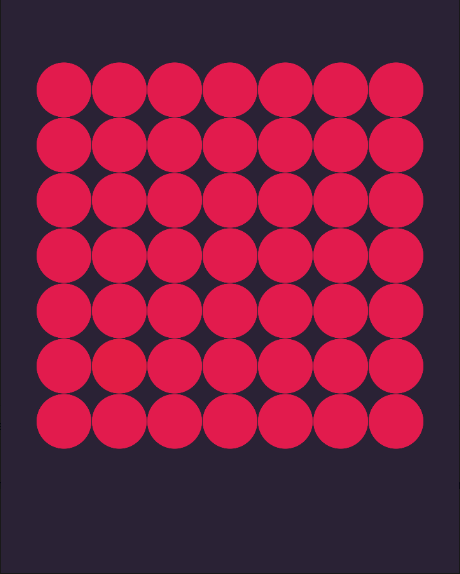

In [36]:
game_play

In [30]:
def drawCircles(img, circles):
    output = img.copy()
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
    return output

Found 33 circles.


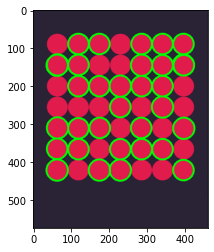

In [56]:
game_play_np = np.array(game_play)
gray = cv2.cvtColor(game_play_np, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1.3, 1)

# convert the (x, y) coordinates and radius of the circles to integers
np_circles = np.round(circles[0, :]).astype("int")
print(f"Found {len(np_circles)} circles.")
output = drawCircles(game_play_np, np_circles)
plt.imshow(output)

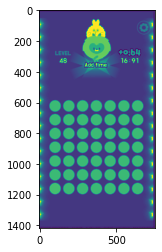

In [589]:
plt.imshow(gray)

In [545]:
modes = scipy.stats.mode(np_circles).mode
modes
cond = np.abs(np_circles[..., 2:]-modes[..., 2:]) <= 2

In [631]:
np_circles

array([[ 211,  746,   46],
       [ 318,  639,   46],
       [ 103,  639,   46],
       [ 318,  962,   46],
       [ 211,  854,   46],
       [ 534,  746,   46],
       [ 211,  962,   46],
       [ 211, 1179,   46],
       [ 534,  854,   45],
       [ 643,  854,   45],
       [ 643, 1070,   45],
       [ 535, 1179,   45],
       [ 103, 1070,   45],
       [ 426, 1070,   45],
       [ 426, 1178,   45],
       [ 534, 1071,   45],
       [ 103, 1178,   45],
       [ 643,  962,   45],
       [ 534,  639,   46],
       [ 643,  639,   46],
       [ 427,  854,   45],
       [ 535, 1070,   45],
       [ 426,  637,   45],
       [ 318, 1070,   46],
       [ 211,  637,   45],
       [ 534,  962,   45],
       [ 427, 1179,   45],
       [ 102, 1071,   45],
       [ 692,  103,   42],
       [ 642, 1178,   45],
       [ 535,  963,   45],
       [ 320,  746,   45],
       [ 535,  637,   45],
       [ 210, 1070,   46],
       [ 103,  747,   46],
       [ 426,  747,   46],
       [ 317, 1179,   46],
 

In [633]:
np_circles

array([[ 211,  746,   46],
       [ 318,  639,   46],
       [ 103,  639,   46],
       [ 318,  962,   46],
       [ 211,  854,   46],
       [ 534,  746,   46],
       [ 211,  962,   46],
       [ 211, 1179,   46],
       [ 534,  854,   45],
       [ 643,  854,   45],
       [ 643, 1070,   45],
       [ 535, 1179,   45],
       [ 103, 1070,   45],
       [ 426, 1070,   45],
       [ 426, 1178,   45],
       [ 534, 1071,   45],
       [ 103, 1178,   45],
       [ 643,  962,   45],
       [ 534,  639,   46],
       [ 643,  639,   46],
       [ 427,  854,   45],
       [ 535, 1070,   45],
       [ 426,  637,   45],
       [ 318, 1070,   46],
       [ 211,  637,   45],
       [ 534,  962,   45],
       [ 427, 1179,   45],
       [ 102, 1071,   45],
       [ 692,  103,   42],
       [ 642, 1178,   45],
       [ 535,  963,   45],
       [ 320,  746,   45],
       [ 535,  637,   45],
       [ 210, 1070,   46],
       [ 103,  747,   46],
       [ 426,  747,   46],
       [ 317, 1179,   46],
 